# References
- https://www.tensorflow.org/text/tutorials/transformer
- https://pytorch.org/tutorials/beginner/translation_tansformer.html
- https://pytorch.org/docs/stable/generated/torch.nn.Transformer.html
- https://arxiv.org/abs/1706.03762

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
from collections import OrderedDict

In [3]:
device = "cuda" if torch.cuda.is_available() else "cpu"

# Position Encoding

$\begin{equation*}\Large
PE_{(pos,2i)} = sin\left(\frac{pos}{10000^{\frac{2i}{d_{model}}}}\right)
\end{equation*}$

$\begin{equation*}\Large
PE_{(pos,2i+1)} = cos\left(\frac{pos}{10000^{\frac{2i}{d_{model}}}}\right)
\end{equation*}$

In [4]:
def positional_encoding(max_seq_len, d_model):
    pos = np.arange(max_seq_len)[:, None]   # [max_seq_len, 1]
    i = np.arange(d_model)[None,:]          # [1, d_model]
    angles = (pos / (10_000**(2*i/d_model))).astype(np.float32)
    angles[:,0::2] = np.sin(angles[:,0::2])
    angles[:,1::2] = np.cos(angles[:,1::2])
    return angles[None,:]   # [1, max_seq_len, d_model]

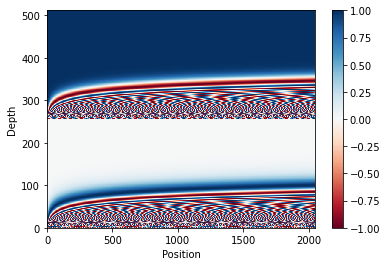

In [5]:
max_seq_len, d_model = 2048, 512
pe = positional_encoding(max_seq_len, d_model)[0]
pe = pe.reshape(max_seq_len, d_model//2, 2)
pe = pe.transpose(2,1,0)
pe = pe.reshape(d_model, max_seq_len)
plt.pcolormesh(pe, cmap='RdBu')
plt.ylabel('Depth')
plt.xlabel('Position')
plt.colorbar()
plt.show()

# Scaled Dot Product Attention

$\begin{equation*}\Large
Attention(Q,K,V) = softmax\left(\frac{QK^{T}}{\sqrt{d_k}}\right)V
\end{equation*}$

In [6]:
def scaled_dot_product_attention(q, k, v, attn_mask=None): # q,k[B, nheads, seq_len, depth]
    scale = q.size(-1)**-0.5
    q = q*scale

    attn = torch.matmul(q, k.transpose(-2,-1)) # [B, nheads, seq_len_q, seq_len_k]
    if attn_mask is not None:
        attn += attn_mask
    attn = attn.softmax(dim=-1)
    # dropout?
    out = torch.matmul(attn, v)    # [B, nheads, seq_len_q, depth_v]
    return out, attn

# Multi headed attention

![multi_head_attention](img/multi_head_attention.png)

In [7]:
class mha(nn.Module):  # multi headed attention
    def __init__(self, d_model=512, nheads=8):
        super().__init__()
        self.nheads = nheads
        self.qw = nn.Linear(d_model, d_model)
        self.kw = nn.Linear(d_model, d_model)
        self.vw = nn.Linear(d_model, d_model)
        self.out_proj = nn.Linear(d_model, d_model)
        self.depth = d_model//nheads

    def forward(self, query, key, value, attn_mask=None):   # [B, seq_len, d_model]
        batch_size, seq_len, d_model = query.shape
        q,k,v = self.qw(query), self.kw(key), self.vw(value) # [B, seq_len, d_model]
        
        q = q.view(batch_size, -1, self.nheads, self.depth)     # [B, seq_len_q, nheads, depth]   # d_model = nheads * depth
        k = k.view(batch_size, -1, self.nheads, self.depth)     # [B, seq_len_k, nheads, depth]
        v = v.view(batch_size, -1, self.nheads, self.depth)     # [B, seq_len_v, nheads, depth]
        
        q = q.transpose(-2,-3)  # [B, nheads, seq_len_q, depth]
        k = k.transpose(-2,-3)  # [B, nheads, seq_len_k, depth]
        v = v.transpose(-2,-3)  # [B, nheads, seq_len_v, depth]
        
        out, attn = scaled_dot_product_attention(q,k,v,attn_mask)   # [B, nheads, seq_len_q, depth]
        
        out = out.transpose(-2,-3)  # [B, seq_len_q, nheads, depth]
        
        out = out.reshape(batch_size, -1, d_model)  # [B, seq_len_q, d_model]
        out = self.out_proj(out)     # [B, seq_len_q, d_model]
        return out, attn

# Transformer

![Transformer](img/transformer.png)

In [8]:
# just for feed forward network in Encoder and Decoder layers
def get_ffn(d_model, dp_rate=0.1, activation='relu'):
    if activation == 'relu':
        act_lyr = nn.ReLU()
    elif activation == 'gelu':
        act_lyr = nn.GELU()
    return nn.Sequential(OrderedDict([
            ('lin1', nn.Linear(d_model, d_model*4)),
            ('activation', act_lyr),
            ('dropout', nn.Dropout(dp_rate)),
            ('lin2', nn.Linear(d_model*4, d_model))
        ]))

In [9]:
class TransformerEncoderLayer(nn.Module):
    def __init__(self, d_model=512, nheads=8, dp_rate=0.1, activation='relu'):
        super().__init__()
        self.attn = mha(d_model=d_model, nheads=nheads)
        self.dropout1 = nn.Dropout(dp_rate)
        self.ln1 = nn.LayerNorm(d_model)
        self.ffn = get_ffn(d_model, dp_rate, activation)
        self.dropout2 = nn.Dropout(dp_rate)
        self.ln2 = nn.LayerNorm(d_model)

    def forward(self, x, attn_mask=None):   # [B, seq_len, d_model]
        x = self.ln1(x + self.dropout1(self.attn(x,x,x, attn_mask)[0]))
        x = self.ln2(x + self.dropout2(self.ffn(x)))
        return x

In [10]:
class TransformerDecoderLayer(nn.Module):
    def __init__(self, d_model=512, nheads=8, dp_rate=0.1, activation='relu'):
        super().__init__()
        self.attn1 = mha(d_model=d_model, nheads=nheads)
        self.dropout1 = nn.Dropout(dp_rate)
        self.ln1 = nn.LayerNorm(d_model)

        self.attn2 = mha(d_model=d_model, nheads=nheads)
        self.dropout2 = nn.Dropout(dp_rate)
        self.ln2 = nn.LayerNorm(d_model)

        self.ffn = get_ffn(d_model, dp_rate, activation)
        self.dropout3 = nn.Dropout(dp_rate)
        self.ln3 = nn.LayerNorm(d_model)
    
    def forward(self, x, enc_output, src_mask=None, tgt_mask=None):   # [B, seq_len, d_model]
        x = self.ln1(x + self.dropout1(self.attn1(x,x,x, tgt_mask)[0]))
        x = self.ln2(x + self.dropout2(self.attn2(x,enc_output,enc_output, src_mask)[0]))
        x = self.ln3(x + self.dropout3(self.ffn(x)))
        return x

In [11]:
class TransformerEncoder(nn.Module):
    def __init__(self, src_vocab_size, nlayers=6, d_model=512, nheads=8, dp_rate=0.1, activation='relu'):
        super().__init__()
        self.d_model = d_model
        self.embedding = nn.Embedding(src_vocab_size, d_model)
        pos_enc = torch.tensor(positional_encoding(max_seq_len, d_model), requires_grad=False)
        self.register_buffer('pos_enc', pos_enc)
        self.enc_layers = nn.ModuleList([TransformerEncoderLayer(d_model, nheads, dp_rate, activation)
                                         for _ in range(nlayers)])   # repeat encoder layer N times
    
    def forward(self, x, src_mask=None):   # [B, seq_len]
        seq_len = x.size(1)
        x = self.embedding(x)               # [B, seq_len, d_model]
        x = x * (self.d_model**0.5)
        x = x + self.pos_enc[:,:seq_len]
        # dropout ?
        for lyr in self.enc_layers:
            x = lyr(x, src_mask)
        return x

In [12]:
class TransformerDecoder(nn.Module):
    def __init__(self, tgt_vocab_size, nlayers=6, d_model=512, nheads=8, dp_rate=0.1, activation='relu'):
        super().__init__()
        self.d_model = d_model
        self.embedding = nn.Embedding(tgt_vocab_size, d_model)
        pos_enc = torch.tensor(positional_encoding(max_seq_len, d_model), requires_grad=False)
        self.register_buffer('pos_enc', pos_enc)
        self.dec_layers = nn.ModuleList([TransformerDecoderLayer(d_model, nheads, dp_rate, activation)
                                         for _ in range(nlayers)])   # repeat decoder layer N times
    
    def forward(self, x, enc_output, src_mask=None, tgt_mask=None):   # [B, seq_len]
        seq_len = x.size(1)
        x = self.embedding(x)              # [B, seq_len, d_model]
        x = x * (self.d_model**0.5)
        x = x + self.pos_enc[:,:seq_len]
        # dropout ?
        for lyr in self.dec_layers:
            x = lyr(x, enc_output, src_mask, tgt_mask)
        return x

In [13]:
class Transformer(nn.Module):
    def __init__(self, src_vocab_size, tgt_vocab_size, d_model=512,
                 nheads=8, nlayers=6, dp_rate=0.1, activation='relu'):
        super().__init__()
        self.encoder = TransformerEncoder(src_vocab_size, nlayers, d_model, nheads, dp_rate, activation)
        self.decoder = TransformerDecoder(tgt_vocab_size, nlayers, d_model, nheads, dp_rate, activation)
        self.fout = nn.Linear(d_model, tgt_vocab_size)
        self.reset_parameters()

    def reset_parameters(self):
        for p in self.parameters():
            if p.dim() > 1:
                nn.init.xavier_uniform_(p)
    
    def forward(self, src, tgt, src_mask=None, tgt_mask=None):   # [B, seq_len]
        x = self.encoder(src, src_mask)
        x = self.decoder(tgt, x, src_mask, tgt_mask)
        x = self.fout(x)
        return x

# Dataset

In [21]:
import torchtext
from torchtext.utils import download_from_url, extract_archive
from torchtext.data.utils import get_tokenizer
from torchtext.vocab import Vocab

from collections import Counter
import io

In [22]:
url_base = 'https://raw.githubusercontent.com/multi30k/dataset/master/data/task1/raw/'
train_urls = ('train.de.gz', 'train.en.gz')
val_urls = ('val.de.gz', 'val.en.gz')
test_urls = ('test_2016_flickr.de.gz', 'test_2016_flickr.en.gz')

In [23]:
train_filepaths = [extract_archive(download_from_url(url_base + url))[0] for url in train_urls]
val_filepaths = [extract_archive(download_from_url(url_base + url))[0] for url in val_urls]
test_filepaths = [extract_archive(download_from_url(url_base + url))[0] for url in test_urls]

In [24]:
train_filepaths

['/home/archer/machine_learning/transformers_pytorch/.data/train.de',
 '/home/archer/machine_learning/transformers_pytorch/.data/train.en']

In [25]:
de_tokenizer = get_tokenizer('spacy', language='de_core_news_sm')
en_tokenizer = get_tokenizer('spacy', language='en_core_web_sm')

In [26]:
def build_vocab(filepath, tokenizer):
    counter = Counter()
    with io.open(filepath, encoding="utf8") as f:
        for string_ in f:
            counter.update(tokenizer(string_.rstrip("\n")))
    return Vocab(counter, specials=['<unk>', '<pad>', '<bos>', '<eos>'])

In [27]:
de_vocab = build_vocab(train_filepaths[0], de_tokenizer)
en_vocab = build_vocab(train_filepaths[1], en_tokenizer)

In [28]:
PAD_IDX = de_vocab['<pad>']
BOS_IDX = de_vocab['<bos>']
EOS_IDX = de_vocab['<eos>']

In [29]:
def data_preprocess(filepaths):
    de_iter = iter(io.open(filepaths[0], encoding="utf8"))
    en_iter = iter(io.open(filepaths[1], encoding="utf8"))
    data = []
    for de_line, en_line in zip(de_iter, en_iter):
        de_tensor = torch.tensor([BOS_IDX] + 
                                 [de_vocab[token] for token in de_tokenizer(de_line.rstrip("\n"))] + 
                                 [EOS_IDX])
        en_tensor = torch.tensor([BOS_IDX] + 
                                 [en_vocab[token] for token in en_tokenizer(en_line.rstrip("\n"))] + 
                                 [EOS_IDX])
        data.append((de_tensor, en_tensor))
    return data

In [30]:
train_data = data_preprocess(train_filepaths)
val_data = data_preprocess(val_filepaths)
test_data = data_preprocess(test_filepaths)

In [31]:
from torch.nn.utils.rnn import pad_sequence
from torch.utils.data import DataLoader

In [32]:
def generate_batch(data_batch):
    de_batch, en_batch = [], []
    for (de_item, en_item) in data_batch:
        de_batch.append(de_item)
        en_batch.append(en_item)
    de_batch = pad_sequence(de_batch, batch_first=True, padding_value=PAD_IDX)
    en_batch = pad_sequence(en_batch, batch_first=True, padding_value=PAD_IDX)
    return de_batch, en_batch

In [33]:
BATCH_SIZE = 32

In [34]:
train_iter = DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True, collate_fn=generate_batch, num_workers=4)
valid_iter = DataLoader(val_data,   batch_size=BATCH_SIZE, shuffle=True, collate_fn=generate_batch, num_workers=4)
test_iter  = DataLoader(test_data,  batch_size=BATCH_SIZE, shuffle=True, collate_fn=generate_batch, num_workers=4)

In [35]:
# a,b = next(iter(train_iter))

In [36]:
# a.shape, b.shape     # [B, seq_len]

# Masking

In [37]:
def subsequent_mask(sz):
    mask = torch.ones((1,1,sz,sz), device=device, dtype=bool).tril()
    mask.logical_not_()
    return mask

def mask_fill_inf(mask):
    return mask.float().masked_fill(mask, float('-inf'))

def create_mask(src, tgt):    # [B, seq_len]
    tgt_mask = subsequent_mask(tgt.size(1))
    
    src_padding_mask = (src == PAD_IDX)[:,None,None,:]    # [B, nheads, seq_len_q, seq_len_k]
    tgt_padding_mask = (tgt == PAD_IDX)[:,None,None,:]    # [B, nheads, seq_len_q, seq_len_k]
    tgt_mask = tgt_mask.logical_or(tgt_padding_mask)      # combine mask for look ahead and tgt padding.
    return mask_fill_inf(src_padding_mask), mask_fill_inf(tgt_mask)

# Model Parameters

In [38]:
import wandb

In [39]:
config_defaults = {
    'src_vocab_size'    : len(de_vocab),
    'tgt_vocab_size'    : len(en_vocab),
    'BATCH_SIZE'        : BATCH_SIZE,
    'd_model'           : 512,
    'nheads'            : 8,
    'nlayers'           : 3,
    'dp_rate'           : 0.1,
    'activation'        : 'relu',
    'lr'                : 0.0001,
    'betas'             : (0.9, 0.98),
    'eps'               : 1e-9,
    'NUM_EPOCHS'        : 20,
    'use_amp'           : True,
    'log_interval'      : 10,
}

In [40]:
# run = wandb.init(id='3nw7bncb', project="Basic_Transformer", resume='must')
# CONFIG = run.config

In [41]:
run = wandb.init(project="Basic_Transformer", entity="shivamshrirao", config=config_defaults)
CONFIG = wandb.config

wandb: Currently logged in as: shivamshrirao (use `wandb login --relogin` to force relogin)


In [42]:
model = Transformer(src_vocab_size = CONFIG['src_vocab_size'],
                    tgt_vocab_size = CONFIG['tgt_vocab_size'],
                    d_model = CONFIG['d_model'],
                    nheads = CONFIG['nheads'],
                    nlayers = CONFIG['nlayers'],
                    dp_rate = CONFIG['dp_rate'],
                    activation = CONFIG['activation']).to(device)

In [43]:
loss_fn = nn.CrossEntropyLoss(ignore_index=PAD_IDX)

optimizer = torch.optim.Adam(
    model.parameters(), lr=CONFIG['lr'], betas=CONFIG['betas'], eps=CONFIG['eps']
)

scaler = torch.cuda.amp.GradScaler(enabled=CONFIG['use_amp'])

In [44]:
wandb.watch(model, criterion=loss_fn, log=None)

In [18]:
from torch.utils.tensorboard import SummaryWriter

In [19]:
writer = SummaryWriter(run.dir+'/tensorboard_logs/custom_transformer')

In [20]:
src, tgt = next(iter(train_iter))
src = src.to(device)
tgt = tgt.to(device)
writer.add_graph(model, (src, tgt))
writer.close()
del src, tgt

In [45]:
def train_epoch(model, train_iter, optimizer, scaler, epoch, use_amp=True, log_interval=10):
    model.train()
    losses = 0
    with tqdm(enumerate(train_iter), total=len(train_iter), desc=f"Epoch {epoch}") as pbar:
        for idx, (src, tgt) in pbar:
            src = src.to(device)
            tgt = tgt.to(device)

            tgt_inp = tgt[:,:-1]      # give input until before the last word.
            tgt_out = tgt[:,1:]       # predict the last word based on input and already predicted sentence. (auto-regressive)

            src_mask, tgt_mask = create_mask(src, tgt_inp)

            with torch.cuda.amp.autocast(enabled=use_amp):
                logits = model(src, tgt_inp, src_mask, tgt_mask)
                loss = loss_fn(logits.reshape(-1, logits.size(-1)), tgt_out.reshape(-1))

            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()
            optimizer.zero_grad(set_to_none=True)

            losses+= loss.item()
            avg_loss = losses/(idx+1)
            if not idx%log_interval:
                wandb.log({"loss": avg_loss})
            pbar.set_postfix({'loss': f"{avg_loss:.3f}"})
    return losses/len(train_iter)

In [46]:
def evaluate(model, val_iter):
    model.eval()
    losses = 0
    with tqdm(enumerate(val_iter), total=len(val_iter), desc="Evaluating") as pbar:
        for idx, (src, tgt) in pbar:
            src = src.to(device)
            tgt = tgt.to(device)

            tgt_inp = tgt[:,:-1]      # give input until before the last word.
            tgt_out = tgt[:,1:]       # predict the last word based on input and already predicted sentence. (auto-regressive)

            src_mask, tgt_mask = create_mask(src, tgt_inp)

            logits = model(src, tgt_inp, src_mask, tgt_mask)

            loss = loss_fn(logits.reshape(-1, logits.size(-1)), tgt_out.reshape(-1))

            losses+= loss.item()
            pbar.set_postfix({'val_loss': f"{losses/(idx+1):.3f}"})
    return losses/len(val_iter)

In [47]:
init_epoch = 1

In [48]:
def save_model(model, optimizer, epoch):
    torch.save({
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'epoch': epoch,
                }, run.dir + '/model.pth')

In [ ]:
# wandb.save("*.pth")

In [50]:
# save_model(model, optimizer, init_epoch)

In [51]:
# checkpoint = torch.load(run.dir + '/model.pth')
# model.load_state_dict(checkpoint['model_state_dict'])
# optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
# init_epoch = checkpoint['epoch']

In [ ]:
for epoch in range(init_epoch, CONFIG['NUM_EPOCHS']+1):
    train_loss = train_epoch(model, train_iter, optimizer, scaler, epoch, CONFIG['use_amp'], CONFIG['log_interval'])
    val_loss = evaluate(model, valid_iter)
    wandb.log({"val_loss": val_loss})
    print(f"Epoch: {epoch}, Train loss: {train_loss:.3f}, Val loss: {val_loss:.3f}\n")
    save_model(model, optimizer, epoch)

Epoch 1:   0%|          | 0/907 [00:00<?, ?it/s]

In [ ]:
run.finish()